In [1]:
GLOBAL_SEED = 7532

from numpy.random import seed
seed(GLOBAL_SEED)
from tensorflow import set_random_seed
set_random_seed(GLOBAL_SEED)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential, load_model
from keras.callbacks import History 
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dense, Dropout, Conv2D, Flatten, MaxPool2D

Using TensorFlow backend.


Read in the data.

In [2]:
train_set = pd.read_csv('train_set_metadata.csv')
valid_set = pd.read_csv('valid_set_metadata.csv')
test_set = pd.read_csv('test_set_metadata.csv')

train_set_partition = np.load('train_set_partition_100_parts.npy')

Compute the number of parts the train set was partitioned into.

In [3]:
n_parts = len(train_set_partition) - 1
n_parts

100

## CNN Model Training from Scratch with Data Augmentation 

In [4]:
BEST_MODEL_PATH = 'best_model.hdf5'
CURRENT_MODEL_PATH = 'current_model.hdf5'

MSE_SCORES_PATH = 'mse_scores.npy'
MAE_SCORES_PATH = 'mae_scores.npy'

INPUT_SHAPE = (320, 320, 3)

EARLY_STOPPING_PATIENCE = 4
LEARNING_RATE = 0.0001
N_EPOCHS = 100
BATCH_SIZE = 8

In [5]:
def create_sequential_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))    
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())  
    
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
 
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    #model.add(Dropout(rate=0.35, seed=GLOBAL_SEED))
    model.add(Dense(units=512, activation='relu'))
    #model.add(Dropout(rate=0.35, seed=GLOBAL_SEED))
    model.add(Dense(units=512, activation='relu'))
    #model.add(Dropout(rate=0.35, seed=GLOBAL_SEED))
    model.add(Dense(units=1, activation='relu'))
    
    return model

In [6]:
model = create_sequential_model(INPUT_SHAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 320, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 320, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 160, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 160, 160, 32)      128       
__________

In [7]:
mse_scores, mae_scores = np.array([]), np.array([])
np.save(MSE_SCORES_PATH, mse_scores)
np.save(MAE_SCORES_PATH, mae_scores)

In [5]:
age_column_position = train_set.columns.get_loc('age')

X_valid = np.load('valid_set_hmgd_arr.npy')
y_valid = valid_set['age'].values

mse_scores, mae_scores= np.load(MSE_SCORES_PATH), np.load(MAE_SCORES_PATH)

for epoch in range(5, 6):
    print(f'Master epoch {epoch + 1}:')
    
    for part in range(n_parts):        
        if (part < 50):
            continue        
        
        print(f'Part {part + 1}:')
    
        train_filename = 'train_set_hmgd_arr_100_parts_' + str(part + 1).zfill(3) + '.npy'
        subrange = range(train_set_partition[part], train_set_partition[part + 1])    
        X_train = np.load(train_filename)
        y_train = train_set.iloc[subrange, age_column_position].values

        # Model initialization/loading
        if (epoch > 0) or (part > 0):
            model = load_model(CURRENT_MODEL_PATH)            
        else:
            model = create_sequential_model(X_train.shape[1:])
            adam = Adam(lr=LEARNING_RATE)
            model.compile(optimizer=adam, 
                          loss='mean_squared_error', 
                          metrics=['mean_absolute_error'])

        history = History()
        model_hist = model.fit(X_train, y_train, batch_size=BATCH_SIZE, callbacks=[history], 
                               verbose=2)
        
        model.save(CURRENT_MODEL_PATH)
        
        #free up memory
        del X_train
        
    epoch_evaluation = model.evaluate(X_valid, valid_set['age'].values)    
    epoch_val_mse = epoch_evaluation[0]
    epoch_val_mae = epoch_evaluation[1]

    print(f'\nMaster epoch {epoch + 1} validation results:\n MSE: {epoch_val_mse}, MAE: {epoch_val_mae}\n\n')
    
    # save best model (if appropriate)
    if mse_scores.size:
        if epoch_val_mse < mse_scores.min():
            model.save(BEST_MODEL_PATH)
    else:
        model.save(BEST_MODEL_PATH)
    
    mse_scores = np.append(mse_scores, epoch_val_mse)
    mae_scores = np.append(mae_scores, epoch_val_mae)
    
    np.save(MSE_SCORES_PATH, mse_scores)
    np.save(MAE_SCORES_PATH, mae_scores) 
    
    # early stopping  
    if mse_scores.size:
        if len(mse_scores) - np.argmin(mse_scores) >= EARLY_STOPPING_PATIENCE:
            break

#free up memory
del X_valid

Master epoch 6:
Part 51:
Epoch 1/1
 - 38s - loss: 38.9708 - mean_absolute_error: 4.7256
Part 52:
Epoch 1/1
 - 35s - loss: 38.7166 - mean_absolute_error: 4.7379
Part 53:
Epoch 1/1
 - 35s - loss: 37.2437 - mean_absolute_error: 4.6912
Part 54:
Epoch 1/1
 - 35s - loss: 39.5170 - mean_absolute_error: 4.7783
Part 55:
Epoch 1/1
 - 35s - loss: 38.8416 - mean_absolute_error: 4.8135
Part 56:
Epoch 1/1
 - 35s - loss: 39.8703 - mean_absolute_error: 4.8038
Part 57:
Epoch 1/1
 - 35s - loss: 36.9306 - mean_absolute_error: 4.6015
Part 58:
Epoch 1/1
 - 35s - loss: 40.0074 - mean_absolute_error: 4.8523
Part 59:
Epoch 1/1
 - 35s - loss: 36.8398 - mean_absolute_error: 4.6285
Part 60:
Epoch 1/1
 - 35s - loss: 36.1097 - mean_absolute_error: 4.5633
Part 61:
Epoch 1/1
 - 36s - loss: 37.1782 - mean_absolute_error: 4.6004
Part 62:
Epoch 1/1
 - 35s - loss: 39.1411 - mean_absolute_error: 4.7065
Part 63:
Epoch 1/1
 - 36s - loss: 38.3858 - mean_absolute_error: 4.7843
Part 64:
Epoch 1/1
 - 36s - loss: 41.2822 - mean

The results below represent the scores calculated every 50 parts (one full master epoch pass is comprised of 100 parts) for 6 full master epochs (run manually every 50 parts due to graphic card memory issues). We can clearly see that after the best MSE score of roughly 97.037 the model performance deteriorates rapidly (the model is overfitting to the training data).

In [7]:
mse_scores, mae_scores = np.load(MSE_SCORES_PATH), np.load(MAE_SCORES_PATH)
pd.DataFrame({'MSE Scores': mse_scores, 'MAE Scores': mae_scores})

,MSE Scores,MAE Scores
0,122.420416,8.587511
1,108.958355,7.962807
2,105.375342,7.870892
3,100.779301,7.633083
4,98.695306,7.521984
5,98.562696,7.509720
6,98.076274,7.429031
7,97.036864,7.397283
8,102.607565,7.602361
9,104.162137,7.643439


Evaluate the model on the test set and get predictions.

In [5]:
X_test = np.load('test_set_hmgd_arr.npy')

In [6]:
model = load_model(BEST_MODEL_PATH)
model.evaluate(X_test, test_set['age'].values)

7621/7621 [==============================] - 40s 5ms/step


[99.40584315134932, 7.422886811972071]

In [7]:
age_preds = model.predict(X_test).flatten()

In [8]:
# free up memory
del X_test

**Visual inspection of predictions and actual values**

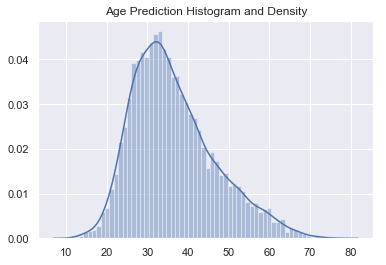

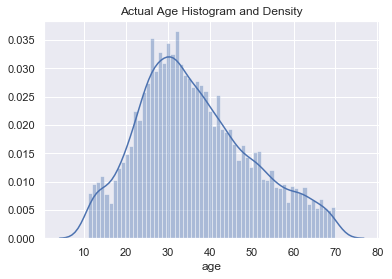

In [9]:
sns.distplot(age_preds, bins=60)
plt.title('Age Prediction Histogram and Density')
plt.show()

sns.distplot(test_set['age'], bins=60)
plt.title('Actual Age Histogram and Density')
plt.show()

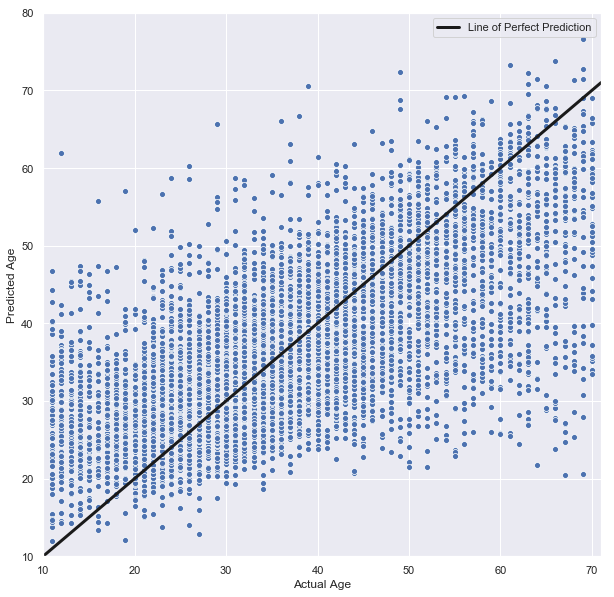

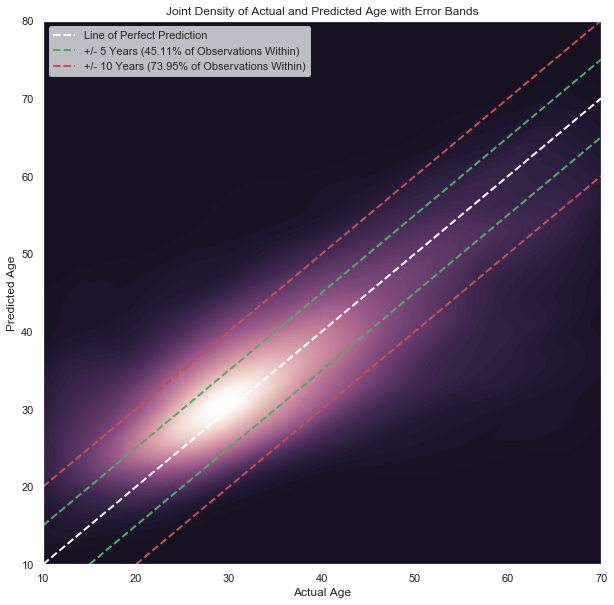

In [10]:
#Scatterplot
plt.figure(figsize=(10, 10))
plt.plot([10, 71], [10, 71], 'k', linewidth=3, label='Line of Perfect Prediction')
sns.scatterplot(test_set['age'].values, age_preds)
plt.xlim((10, 71))
plt.ylim((10, 80))
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()


#Density plot with error bands
within_5_years = (np.abs(age_preds - test_set['age'].values) <=5).mean()
within_5_years = np.round(100 * within_5_years, 2)
within_10_years = (np.abs(age_preds - test_set['age'].values) <=10).mean()
within_10_years = np.round(100 * within_10_years, 2)

plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.075, light=1, reverse=True)
sns.kdeplot(test_set['age'].values, age_preds, cmap=cmap, n_levels=100, shade=True, 
            clip=[(10, 70), (10, 80)])
plt.plot([10, 70], [10, 70], 'w--', linewidth=2, 
         label='Line of Perfect Prediction')
plt.plot([10, 70], [15, 75], 'g--', linewidth=2, 
         label=f'+/- 5 Years ({within_5_years}% of Observations Within)')
plt.plot([15, 70], [10, 65], 'g--', linewidth=2)
plt.plot([10, 70], [20, 80], 'r--', linewidth=2, 
         label=f'+/- 10 Years ({within_10_years}% of Observations Within)')
plt.plot([20, 70], [10, 60], 'r--', linewidth=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend(loc='upper left')
plt.title('Joint Density of Actual and Predicted Age with Error Bands')
plt.show()